rpm_max =  771.7550514480479
continuous model
a =  [[-101.25556906]]
b =  [[8183.27257999]]



<Figure size 640x480 with 0 Axes>

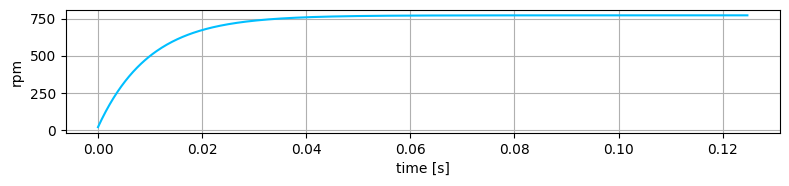

In [10]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#parameters from identification

#sampling frequency, 4kHz
dt       = 1.0/4000.0


u_max       = 1.0
k           = 80.818    # motor constant 
rad_var     = 12.788    # (rad/s)^2 variance (encoder noise)
tau         = 9.876     # motor time constant, milliseconds



rpm_max = u_max*k*60.0/(2.0*numpy.pi)

print("rpm_max = ", rpm_max)


#continuous time dynamics
mat_a = numpy.zeros((1, 1))
mat_b = numpy.zeros((1, 1))
mat_c = numpy.eye(1)
 
tau = tau*0.001
mat_a[0][0] = -1.0/tau    
mat_b[0][0] = k*(1.0/tau)


print("continuous model")
print("a = ", mat_a)
print("b = ", mat_b)
print()


#create dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, mat_c, dt)


#compute step response
t_result = []
u_result = []
x_result = []


for n in range(500):

    # unit step as input
    u = numpy.ones((1, 1))

    x, _ = ds.forward_state(u)

    t_result.append(n*dt)
    x_result.append(x[:, 0])

t_result = numpy.array(t_result)
x_result = numpy.array(x_result)

#plot result
LibsControl.plot_open_loop_response(t_result, x_result*60.0/(2.0*numpy.pi), file_name = "step_response.png", labels = ["rpm"])




In [11]:

#custom tune PID parameters


kp  = 0.01
ki  = 0.0002
kd  = 0.0


'''
kp  = 0.01
ki  = 0.005
kd  = 0.0
'''

pid = LibsControl.PID(kp, ki, kd)


<Figure size 640x480 with 0 Axes>

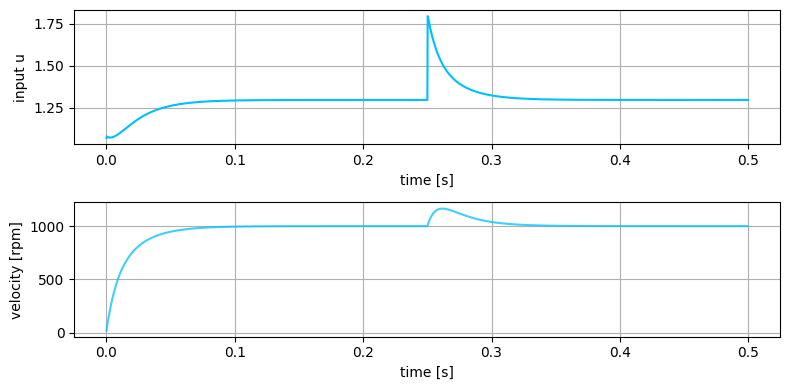

In [12]:

#process simulation

n_max = 2000

#required output, 1000rpm
rpm_req = 1000

yr = numpy.zeros((mat_c.shape[0], 1))
yr[0][0] = (rpm_req/60.0)*(2.0*numpy.pi) 



#initial error integral
u = 0.0

#result log
t_result = []
u_result = []
u_in_result = []
x_result = []



#initial motor state
ds.reset()

#plant output
y = ds.y

for n in range(n_max):

    #compute controller output
    u = pid.forward(yr[0][0], y[0][0], u)


    u_in = numpy.array([[u]])

    #add constant disturbance in middle
    if n > n_max//2:
        u_in[0]+= 0.5
 
    #compute plant output
    x, y = ds.forward_state(u_in)
  
    

    t_result.append(n*dt)
    u_result.append(u_in[:, 0].copy())
    x_result.append(x[:, 0].copy())

    
    
t_result = numpy.array(t_result)
x_result = numpy.array(x_result)
u_result = numpy.array(u_result)

#convert rps to rpm
x_result[:, 0]*= 60.0/(2.0*numpy.pi)

#plot results
LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "pid_discrete_output.png", u_labels = ["input u"], x_labels = ["velocity [rpm]"])
